# ADA Group 9 - Assignment 2

# Task

Use the One-piece [competition case](https://www.kaggle.com/t/f5f7783abf31495f9593b3d93a18f9eb).

1. Read the training sample to a Pandas dataframe.
1. Extending Assignment 1, now consider multiple linear regression models.
$$y=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_Kx_K + \epsilon$$
1. Choose **one** multiple linear regression model and make predictions from the test data set.
    - Clearly, model choice is an art now...
    - Possibly, use forward search or backward search,
    - or try Benjamini-Hochberg method,
    - or consider some K-fold method for model selection,
    - or use your experience to select key variables,
    - or eavesdrop your rivals,
    - or create new variables based on existing ones,
    - or Lasso it,
    - or some technique combination.
    - This is a typical example of open-ended questions.
1. Get the test sample for prediction and submit your results on Kaggle to get your Kaggle score screenshot. Show the screenshot in the PDF file.

## Install Packages

In [39]:
import pandas as pd
import numpy as np
import plotly.express as px # pyright: ignore[reportMissingImports] t
import plotly.graph_objects as go # pyright: ignore[reportMissingImports] t
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, LassoCV, ElasticNetCV, ElasticNet, RidgeCV, Ridge # pyright: ignore[reportMissingModuleSource]
from sklearn.model_selection import train_test_split, GridSearchCV # pyright: ignore[reportMissingModuleSource]
from sklearn.preprocessing import StandardScaler # pyright: ignore[reportMissingModuleSource]
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error, make_scorer # pyright: ignore[reportMissingModuleSource]
import statsmodels.api as sm # pyright: ignore[reportMissingImports] 

## 1. Read Data

In [40]:
train_df = pd.read_csv('../data/train_data.csv')
train_df.head()

,ID,Y,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0,-1.399091,1.174139,1.413109,0.164693,-1.067338,0.015324,-1.280970,0.489681,-0.371982,...,-0.115044,-2.580043,-0.812428,0.772820,-0.460444,0.190422,-0.362052,-1.119038,0.916313,-1.517434
1,1,3.097990,0.208922,0.931231,0.838779,0.893483,-0.510555,0.900289,-0.042490,0.839400,...,1.155635,0.673035,-0.438152,-0.001316,-0.761800,1.335092,0.901978,-1.549504,-0.456224,0.223405
2,2,-1.707346,-0.744982,0.962118,0.615392,-0.427943,-0.014912,1.138781,1.159491,0.055467,...,0.299277,1.387495,-0.007519,-0.464825,0.830986,0.373124,0.319232,-0.577295,-1.363846,-0.347154
3,3,0.610625,-0.170428,-1.361771,0.206042,0.623124,0.907441,-0.873814,1.287383,0.901191,...,1.209247,0.095866,-0.287905,-1.110714,-1.660352,0.207231,-0.419119,-0.517563,-1.050697,-0.096327
4,4,-0.689196,-0.858792,0.321308,-0.415649,1.014056,-0.522858,0.926634,-0.390663,0.790054,...,-1.191989,-1.127448,0.246358,0.407769,1.132454,-0.016621,0.964745,0.091532,0.649593,-0.818020


## 2. LASSO with K-fold CV

In this section, we begin with LASSO regularisation to reduce our parameter scope using cross-validation.

First, we scale the predictors to ensure comparability.

In [41]:
# Separate the X predictors and Y outcome variable
X0_train = train_df.drop(columns=['Y', 'ID'])
y0_train = train_df['Y'].values

# Scale the predictors
scaler = StandardScaler()
X1_train = scaler.fit_transform(X0_train)

Second, we select the 'optimal' alpha for LASSO regularisation (which we combine with cross-validation).

In [42]:
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 2, num=100), cv=10, max_iter=10000)

# Fit the LassoCV model to the scaled training data
lasso_cv_model.fit(X1_train, y0_train)

# The optimal alpha selected by cross-validation
optimal_alpha_lasso = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha_lasso)

Optimal Alpha: 0.034304692863149154


In [43]:
lasso_cv_model = Lasso(alpha=optimal_alpha_lasso)
lasso_cv_model.fit(X1_train, y0_train)
lasso_cv_model

Lasso(alpha=0.034304692863149154)

## 3. Ridge Regularisation with K-fold CV

In this section, we use ridge regularisation to reduce our parameter scope using cross-validation.

In [44]:
ridge_cv_model = RidgeCV(alphas=np.logspace(-5, 2, num=100), cv=10, scoring='neg_mean_squared_error')

# Fit the RidgeCV model to the scaled training data
ridge_cv_model.fit(X1_train, y0_train)

# The optimal alpha selected by cross-validation
optimal_alpha_ridge = ridge_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha_ridge)

Optimal Alpha: 72.20809018385457


In [45]:
ridge_cv_model = Ridge(alpha=optimal_alpha_ridge)
ridge_cv_model.fit(X1_train, y0_train)
ridge_cv_model

Ridge(alpha=72.20809018385457)

## 4. ElasticNet with K-fold CV

In this section, we expand on our use of LASSO and we use ElasticNet. This essentially incorporates both LASSO and Ridge regression for parameter regularisation.

In [46]:
# elastic net and cross-validation
alphas = np.logspace(-5, 2, 100)  # Range of alpha values to test
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]  # Range of l1_ratio values to test
elastic_net = ElasticNetCV(alphas=np.logspace(-5, 2, 100), l1_ratio=l1_ratios, cv=10, max_iter=10000, n_jobs=-1)
elastic_net.fit(X1_train, y0_train)
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_

# results
print(best_alpha, best_l1_ratio)

0.034304692863149154 1.0


Let us compare LASSO CV, Ridge CV, and ElasticNet CV to OLS on a graph to see the effects of regularisation.

In [47]:
# Get the coefficients and feature names for Lasso and ElasticNet
lasso_coefficients = lasso_cv_model.coef_
elastic_net_coefficients = elastic_net.coef_
ridge_coefficients = ridge_cv_model.coef_
feature_names = X0_train.columns

# Initialize the OLS regression model
ols_model = LinearRegression()
# Fit the OLS model to the training data
ols_model.fit(X1_train, y0_train)
# Get the coefficients for OLS
ols_coefficients = ols_model.coef_

# Create DataFrames for Lasso and OLS coefficients
lasso_coeff_df = pd.DataFrame({'Feature': feature_names, 'LASSO Coefficient': lasso_coefficients})
elastic_net_coeff_df = pd.DataFrame({'Feature': feature_names, 'ElasticNet Coefficient': elastic_net_coefficients})
ridge_coeffcients_df = pd.DataFrame({'Feature': feature_names, 'Ridge Coefficient': ridge_coefficients})
ols_coeff_df = pd.DataFrame({'Feature': feature_names, 'OLS Coefficient': ols_coefficients})

# Combine the DataFrames
combined_coeff_df = pd.merge(ols_coeff_df, lasso_coeff_df, on='Feature')
combined_coeff_df = pd.merge(combined_coeff_df, elastic_net_coeff_df, on='Feature')
combined_coeff_df = pd.merge(combined_coeff_df, ridge_coeffcients_df, on='Feature')

# Create an interactive scatter plot using Plotly
fig = px.scatter(combined_coeff_df, x='Feature', y=['OLS Coefficient', 'LASSO Coefficient', 'ElasticNet Coefficient', 'Ridge Coefficient'],
                 title='OLS vs LASSO vs Ridge vs ElasticNet Coefficients', labels={'value': 'Coefficient'})

# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'})

# Show the interactive plot
fig.show()

As can be observed, we still recover a majority of our parameters in all regularisation techniques.

# 4. Model Evaluation

In [48]:
lasso_cv_mse = -cross_val_score(
    lasso_cv_model, 
    X1_train, 
    y0_train,
    cv=10,
    scoring="neg_mean_squared_error"
)
print("Mean CV MSE:", np.mean(lasso_cv_mse))
print("Mean CV RMSE:", np.sqrt(np.mean(lasso_cv_mse)))

Mean CV MSE: 7.399768681029597
Mean CV RMSE: 2.720251584142466


In [49]:
ridge_cv_mse = -cross_val_score(
    ridge_cv_model, 
    X1_train, 
    y0_train,
    cv=10,
    scoring="neg_mean_squared_error"
)
print("Mean CV MSE:", np.mean(ridge_cv_mse))
print("Mean CV RMSE:", np.sqrt(np.mean(ridge_cv_mse)))

Mean CV MSE: 7.442807161081619
Mean CV RMSE: 2.7281508684604705


In [50]:
elastic_net_cv_mse = -cross_val_score(
    elastic_net, 
    X1_train, 
    y0_train,
    cv=10,
    scoring="neg_mean_squared_error"
)

print("Mean CV MSE:", np.mean(elastic_net_cv_mse))
print("Mean CV RMSE:", np.sqrt(np.mean(elastic_net_cv_mse)))

Mean CV MSE: 7.411231813570614
Mean CV RMSE: 2.7223577673719914


Given that LASSO has a smaller MSE than Ridge and Elastic Net, we use LASSO for our predictions. This is not a surprise as the L1 ratio for the Elastic Net is 1.

# 5. Model Prediction

In [51]:
test_df = pd.read_csv('../data/test_data.csv')
test_X0 = test_df.drop(columns=['ID'])
test_X1 = scaler.transform(test_X0)

# Predict Y using Lasso
Y_pred = lasso_cv_model.predict(test_X1)

# Create the data frame with each ID and the predicted Y value

test_df['Y_pred'] = Y_pred
pred_df = test_df[['ID', 'Y_pred']]

#print(submission_df.head())

submission_ass2 = pd.read_csv('../data/submission.csv')
submission_ass2['Y'] = pred_df[['Y_pred']].values
submission_ass2.to_csv("submission_ass2_group9.csv", index=False)

![Leaderboard Screenshot.png](<attachment:Leaderboard Screenshot.png>)
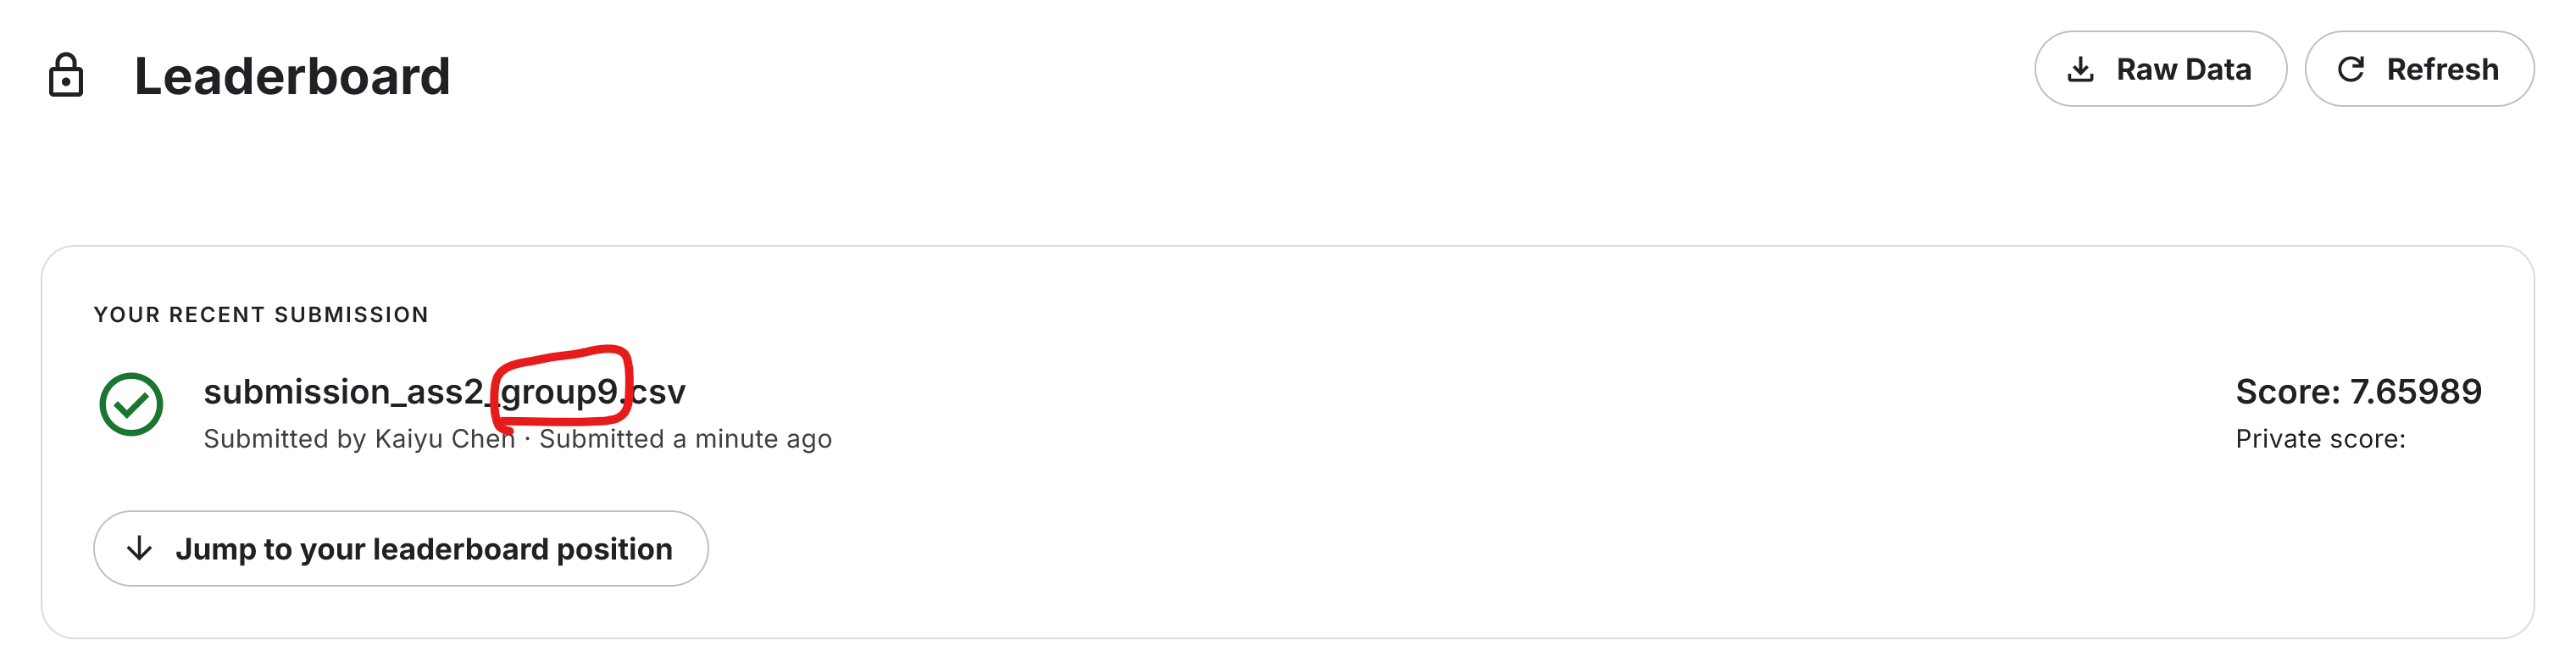